In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import joblib


In [2]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [3]:
df = pd.read_csv("/content/US_Crime_DataSet.csv")
print("Initial shape:", df.shape)

<ipython-input-3-49d63b9bd42f>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/US_Crime_DataSet.csv")


Initial shape: (638454, 24)


In [4]:
columns_to_clean = ['Victim Age', 'Perpetrator Age']
for col in columns_to_clean:
    df[col] = df[col].replace(['Unknown', '0', 0], np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [5]:
df = df.dropna(subset=['Victim Age', 'Perpetrator Age'])

In [6]:
df['Year'] = df['Year'].astype(int)

<ipython-input-6-91b4af12fd7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype(int)


In [7]:
print("Shape after cleaning:", df.shape)

Shape after cleaning: (414873, 24)


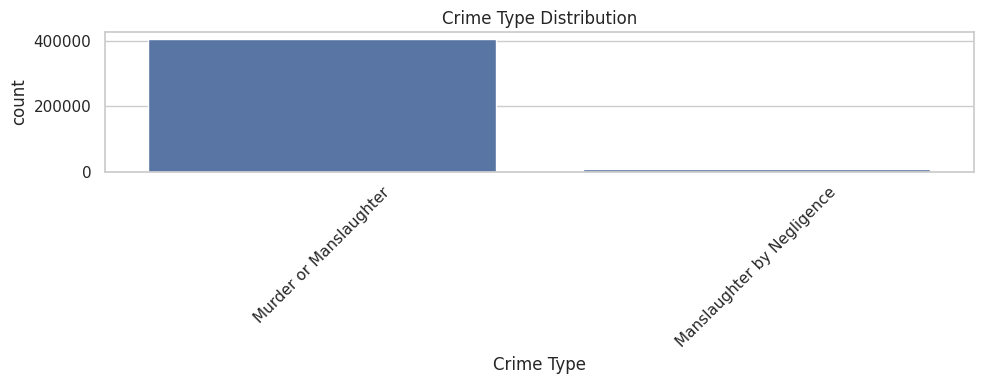

In [8]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Crime Type')
plt.title('Crime Type Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-9-051adfc73076>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Crime Solved', palette='Set2')


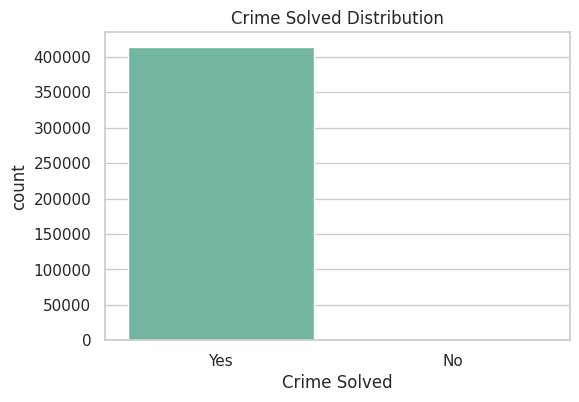

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Crime Solved', palette='Set2')
plt.title('Crime Solved Distribution')
plt.show()

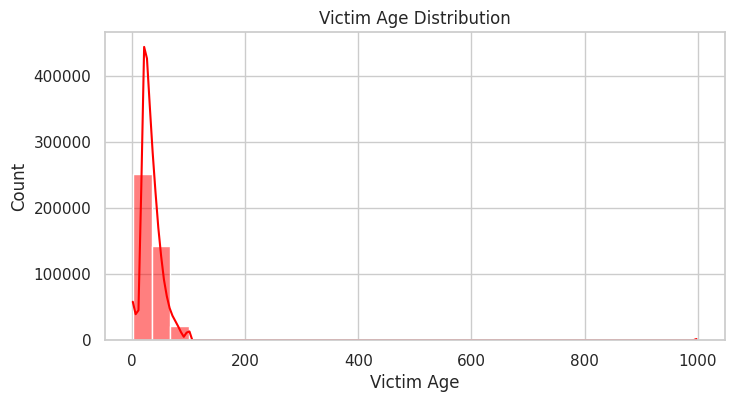

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Victim Age'], bins=30, kde=True, color='red')
plt.title('Victim Age Distribution')
plt.show()

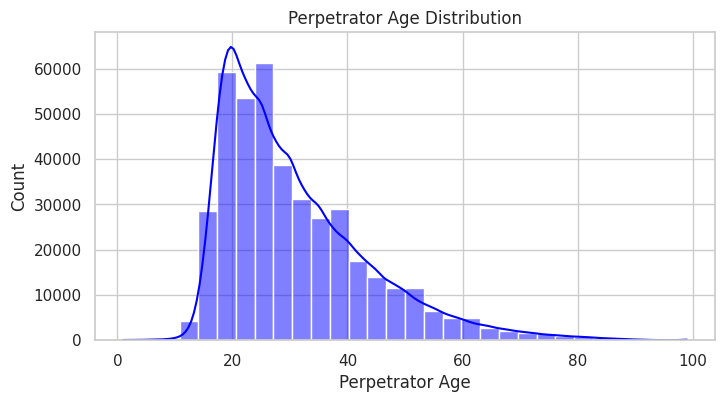

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Perpetrator Age'], bins=30, kde=True, color='blue')
plt.title('Perpetrator Age Distribution')
plt.show()

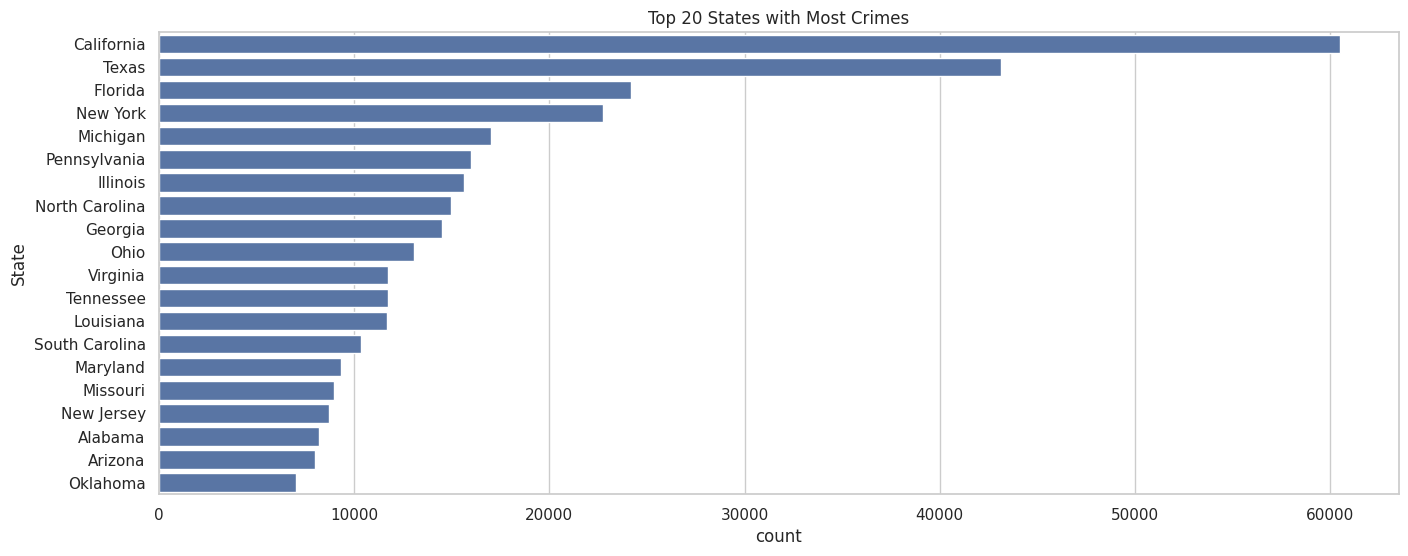

In [12]:
plt.figure(figsize=(16, 6))
sns.countplot(data=df, y='State', order=df['State'].value_counts().index[:20])
plt.title('Top 20 States with Most Crimes')
plt.show()

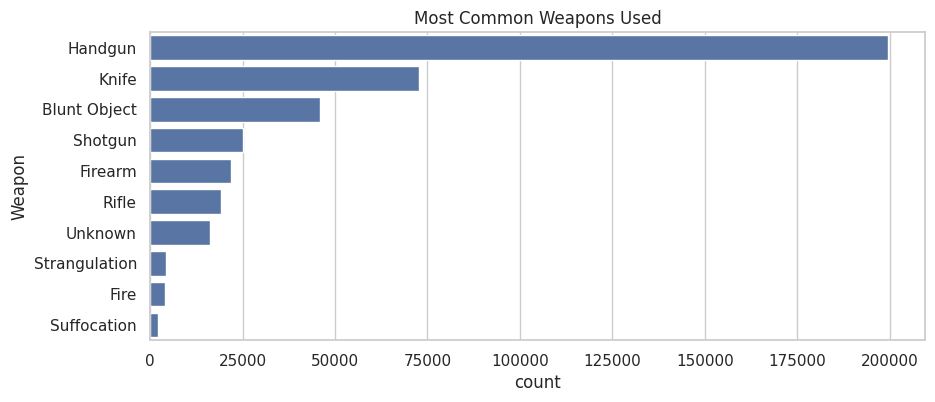

In [13]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, y='Weapon', order=df['Weapon'].value_counts().index[:10])
plt.title('Most Common Weapons Used')
plt.show()

In [14]:
def detect_and_remove_outliers_iqr_plot(df, column):
    plt.figure(figsize=(10, 5))


    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[column], color='orange')
    plt.title(f'{column} - Before Outlier Removal')


    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean = df[(df[column] >= lower) & (df[column] <= upper)]


    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean[column], color='green')
    plt.title(f'{column} - After Outlier Removal')

    plt.tight_layout()
    plt.show()

    return df_clean


In [15]:
df.columns

Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')

In [16]:
df.dtypes

,0
Record ID,int64
Agency Code,object
Agency Name,object
Agency Type,object
City,object
State,object
Year,int64
Month,object
Incident,int64
Crime Type,object


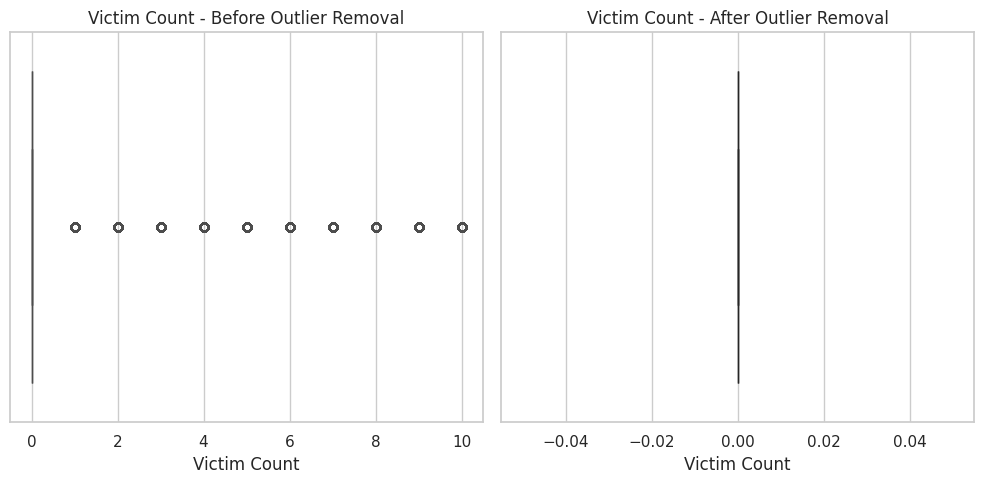

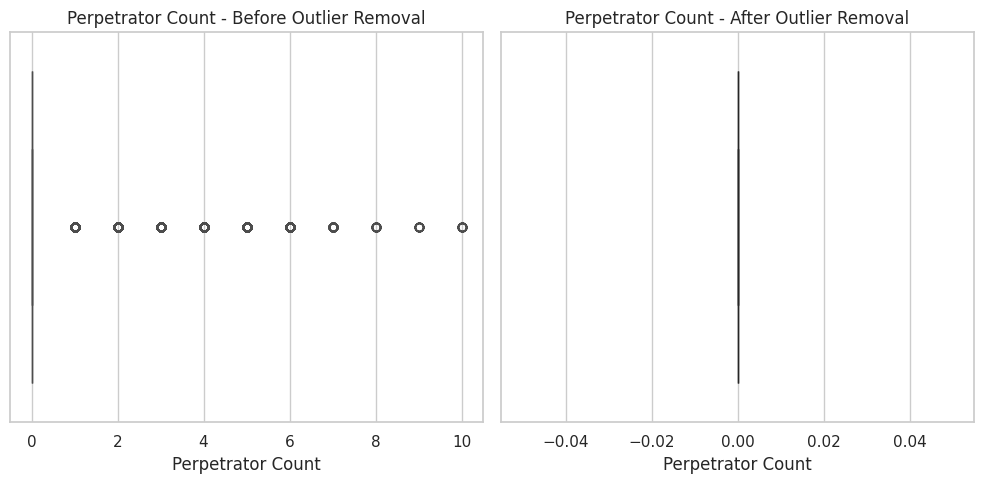

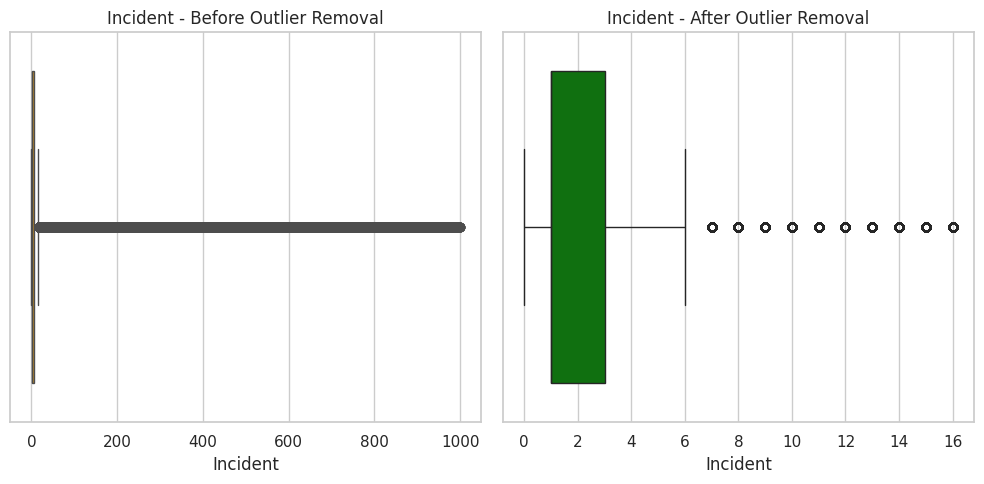

In [17]:
df = detect_and_remove_outliers_iqr_plot(df, 'Victim Count')
df = detect_and_remove_outliers_iqr_plot(df, 'Perpetrator Count')
df = detect_and_remove_outliers_iqr_plot(df, 'Incident')

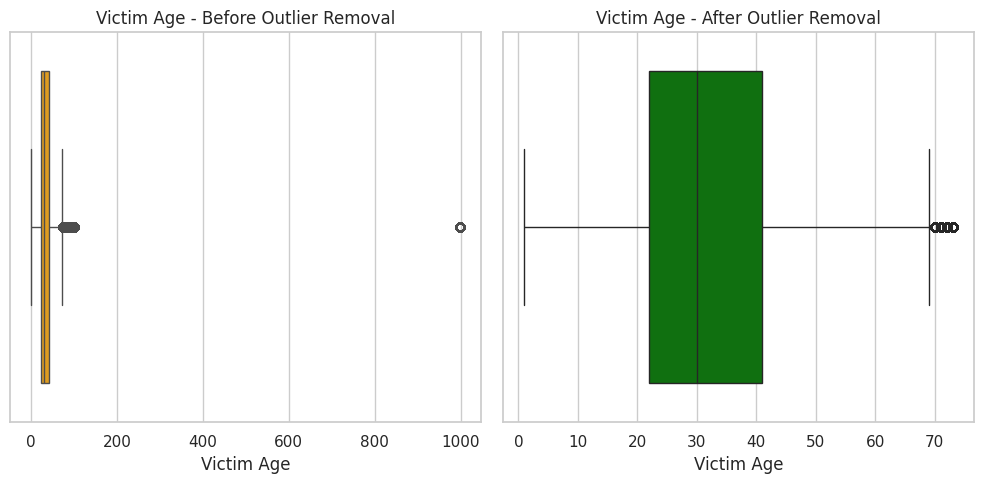

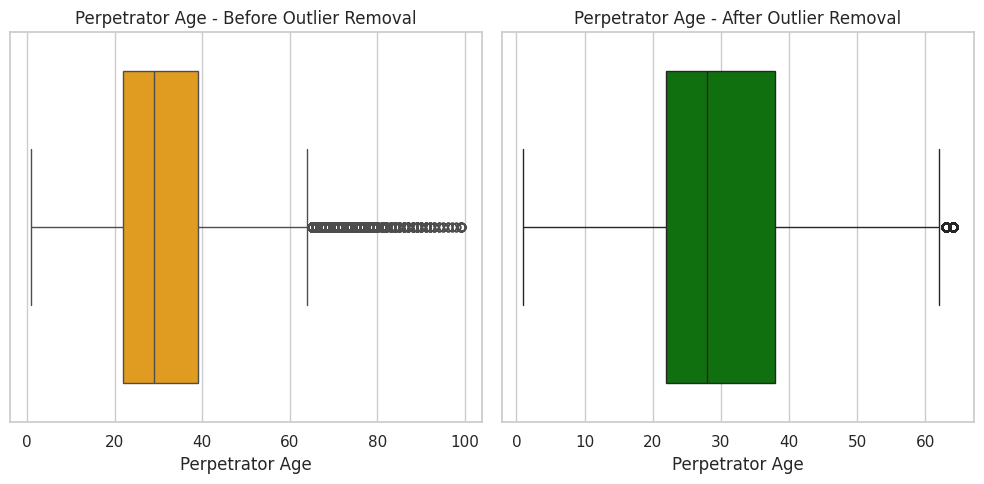

In [18]:
df = detect_and_remove_outliers_iqr_plot(df, 'Victim Age')
df = detect_and_remove_outliers_iqr_plot(df, 'Perpetrator Age')

In [19]:
agg_df = df.groupby(['State', 'Year']).agg({
    'Incident': 'count',
    'Victim Age': 'mean',
    'Perpetrator Age': 'mean',
    'Victim Sex': lambda x: x.mode()[0],
    'Perpetrator Sex': lambda x: x.mode()[0],
    'Weapon': lambda x: x.mode()[0],
    'Agency Type': lambda x: x.mode()[0],
    'Crime Solved': lambda x: (x == 'Yes').mean()
}).reset_index()

agg_df.rename(columns={
    'Incident': 'Total Crimes',
    'Crime Solved': 'Solved Ratio'
}, inplace=True)

In [20]:
threshold = agg_df['Total Crimes'].quantile(0.7)
agg_df['High Crime Risk'] = (agg_df['Total Crimes'] >= threshold).astype(int)

In [21]:
le = LabelEncoder()
for col in ['Victim Sex', 'Perpetrator Sex', 'Weapon', 'Agency Type']:
    agg_df[col] = le.fit_transform(agg_df[col])

X = agg_df.drop(['State', 'Total Crimes', 'High Crime Risk'], axis=1)
y = agg_df['High Crime Risk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [23]:
pip install xgboost

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("\n Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       363
           1       0.59      0.51      0.55       164

    accuracy                           0.74       527
   macro avg       0.69      0.67      0.68       527
weighted avg       0.73      0.74      0.73       527



In [26]:
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("\n Logistic Regression Report:")
print(classification_report(y_test, lr_preds))


 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.68      0.98      0.81       363
           1       0.00      0.00      0.00       164

    accuracy                           0.68       527
   macro avg       0.34      0.49      0.40       527
weighted avg       0.47      0.68      0.56       527



In [27]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\n XGBoost Classifier Report:")
print(classification_report(y_test, xgb_preds))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:09:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       363
           1       0.60      0.55      0.57       164

    accuracy                           0.75       527
   macro avg       0.70      0.69      0.70       527
weighted avg       0.74      0.75      0.74       527



In [28]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
print("\n K-Nearest Neighbors Report:")
print(classification_report(y_test, knn_preds))


 K-Nearest Neighbors Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       363
           1       0.57      0.55      0.56       164

    accuracy                           0.73       527
   macro avg       0.69      0.68      0.69       527
weighted avg       0.73      0.73      0.73       527



In [29]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("\n Support Vector Machine Report:")
print(classification_report(y_test, svm_preds))


 Support Vector Machine Report:
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       363
           1       0.61      0.20      0.30       164

    accuracy                           0.71       527
   macro avg       0.67      0.57      0.56       527
weighted avg       0.69      0.71      0.66       527



In [30]:
models = {
    "Random Forest": accuracy_score(y_test, rf_preds),
    "Logistic Regression": accuracy_score(y_test, lr_preds),
    "XGBoost": accuracy_score(y_test, xgb_preds),
    "KNN": accuracy_score(y_test, knn_preds),
    "SVM": accuracy_score(y_test, svm_preds)
}

<ipython-input-31-1f894b88ac9c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.values()), y=list(models.keys()), palette="viridis")


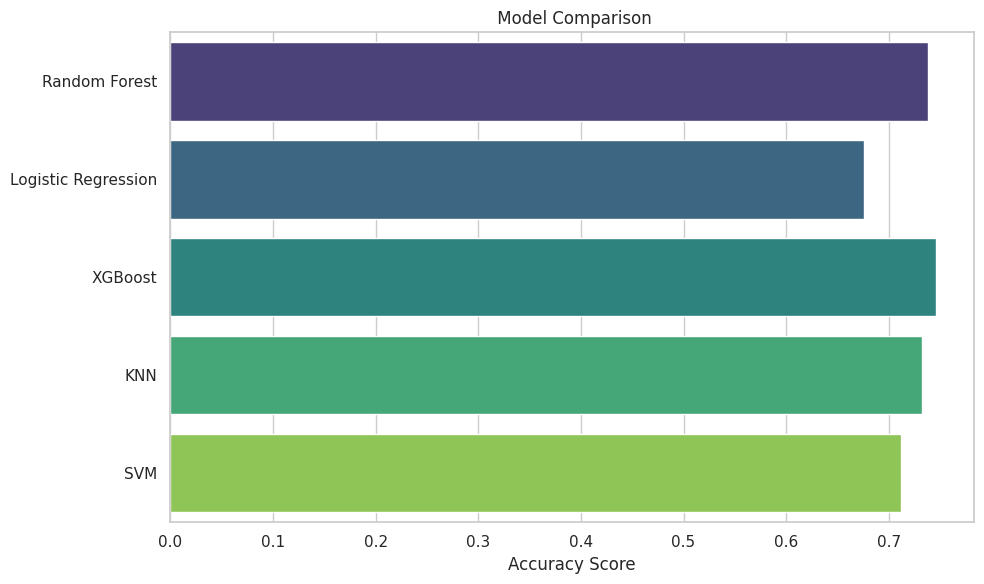

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(models.values()), y=list(models.keys()), palette="viridis")
plt.xlabel("Accuracy Score")
plt.title(" Model Comparison")
plt.tight_layout()
plt.show()

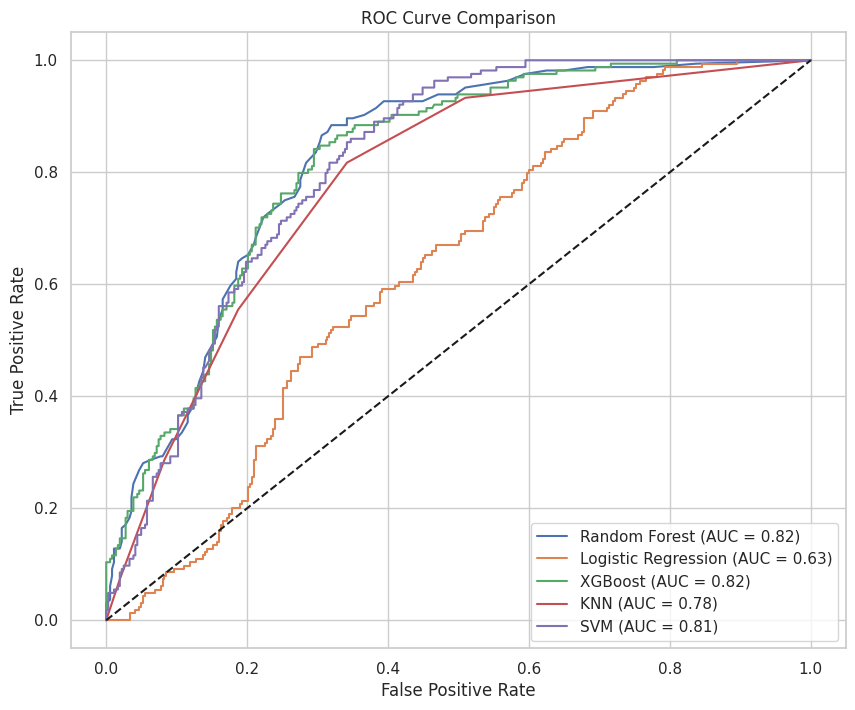

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# For ROC Curves (only works for binary classification)
models_list = [
    ('Random Forest', rf_model),
    ('Logistic Regression', lr_model),
    ('XGBoost', xgb_model),
    ('KNN', knn_model),
    ('SVM', svm_model)
]

plt.figure(figsize=(10, 8))
for name, model in models_list:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        continue  # Skip models without predict_proba
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [33]:
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(lr_model, "lr_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(knn_model, "knn_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [34]:
agg_df.to_csv("/content/processed_agg_df.csv", index=False)

In [35]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [36]:
import gradio as gr
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load models and scaler if needed (not used directly here, but could be extended)
scaler = joblib.load("scaler.pkl")

# Load preprocessed data
df = pd.read_csv("/content/US_Crime_DataSet.csv")

# Clean same as in training pipeline
df['Victim Age'] = pd.to_numeric(df['Victim Age'].replace(['Unknown', '0', 0], pd.NA), errors='coerce')
df['Perpetrator Age'] = pd.to_numeric(df['Perpetrator Age'].replace(['Unknown', '0', 0], pd.NA), errors='coerce')
df = df.dropna(subset=['Victim Age', 'Perpetrator Age'])
df['Year'] = df['Year'].astype(int)

# Function to get state-level stats
def state_crime_summary(selected_state):
    state_df = df[df['State'] == selected_state]

    total_crimes = len(state_df)
    solved_ratio = (state_df['Crime Solved'] == 'Yes').mean() * 100
    avg_victim_age = state_df['Victim Age'].mean()
    avg_perp_age = state_df['Perpetrator Age'].mean()
    common_weapon = state_df['Weapon'].mode()[0] if not state_df['Weapon'].mode().empty else "N/A"

    # Create visual
    plt.figure(figsize=(6, 3))
    sns.countplot(data=state_df, x='Crime Type', order=state_df['Crime Type'].value_counts().index[:5], palette='magma')
    plt.title(f"Top Crime Types in {selected_state}")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_path = "state_crime_plot.png"
    plt.savefig(plot_path)
    plt.close()

    summary = (
        f" **State**: {selected_state}\n"
        f" **Total Crimes**: {total_crimes}\n"
        f" **Crime Solved Rate**: {solved_ratio:.2f}%\n"
        f" **Avg Victim Age**: {avg_victim_age:.1f}\n"
        f" **Avg Perpetrator Age**: {avg_perp_age:.1f}\n"
        f"**Most Common Weapon**: {common_weapon}"
    )

    return summary, plot_path

# List of available states
state_list = sorted(df['State'].unique())

# Interface
with gr.Blocks(theme=gr.themes.Soft()) as dashboard:
    gr.Markdown("##  US Crime Insight Dashboard")
    gr.Markdown("Select a US state to explore its crime profile ")

    with gr.Row():
        state_dropdown = gr.Dropdown(choices=state_list, label="Select a State")
        output_summary = gr.Markdown()

    output_plot = gr.Image(type="filepath", label="Top Crimes Visual")

    state_dropdown.change(fn=state_crime_summary, inputs=state_dropdown, outputs=[output_summary, output_plot])

dashboard.launch()


<ipython-input-36-375ed931f0d4>:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/US_Crime_DataSet.csv")
<ipython-input-36-375ed931f0d4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype(int)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://35f4a63268f5cfd7cb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
